In [26]:
import numpy as np

import awkward as ak
import uproot as uproot

import scipy.special as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pprint

## Setup

In [36]:
# Path to the root file
file_path = "/home/amaterasu/work/cm_meeting_hk/datasets/processed_root_datasets/e_mu_20k_v1_processed.root"
tree_name = 'tree_with_cuts'

# Path to the folder to saves plots
# Don't forget the last '/'
viz_folder_path = "/home/amaterasu/work/cm_meeting_hk/viz/"

# Path to the folder containing .npy files
# Don't forget the last '/'
npy_folder_path = '/home/amaterasu/work/cm_meeting_hk/npz_files/'


## Load the files

#### -- Root dataset

In [28]:
file = uproot.open(file_path)
print(f"File keys :  \n{file.keys()}")

tree = file[tree_name]
pprint.pprint(f"Tree keys :  \n{tree.keys()}")

File keys :  
['tree_with_cuts;1']
('Tree keys :  \n'
 "['eventType', 'event_id', 'nb_triggers_in_event', 'trigger_time', "
 "'trigger_type', 'energy', 'vertex', 'vertex_time', 'particleDir', "
 "'particleStart', 'particleStop', 'n_hits', 'n_digits', 'charge', 'time', "
 "'hitx', 'hity', 'hitz']")


#### -- Model's output

In [29]:
indices, preds, targets = np.load(npy_folder_path + 'indices.npy'), np.load(npy_folder_path + 'preds.npy'), np.load(npy_folder_path + 'targets.npy')

print(f"Indices : {indices[:10]} \nPreds : {preds[:10]} \nTargets : {targets[:10]}")

Indices : [10758 32097 28883   254 18005 11758 36658 16845 28314 11268] 
Preds : [[ 0.32026944  0.5163257 ]
 [ 2.3750331  -2.401381  ]
 [ 0.53768027 -2.026301  ]
 [ 0.3778031   0.80712783]
 [ 0.8593144   0.17077361]
 [ 0.03767109  0.7922499 ]
 [ 2.1333585  -2.7183592 ]
 [ 0.93383056 -0.7197345 ]
 [ 3.7443042  -5.243843  ]
 [ 0.48161417 -0.17456612]] 
Targets : [1 0 0 1 1 1 0 1 0 1]


## Check of the data

In [30]:
np.unique(tree['eventType'].array()[indices], return_counts=True)

<Array [[11, 13], [4521, 4179]] type='2 * var * int64'>

### ROC Curves

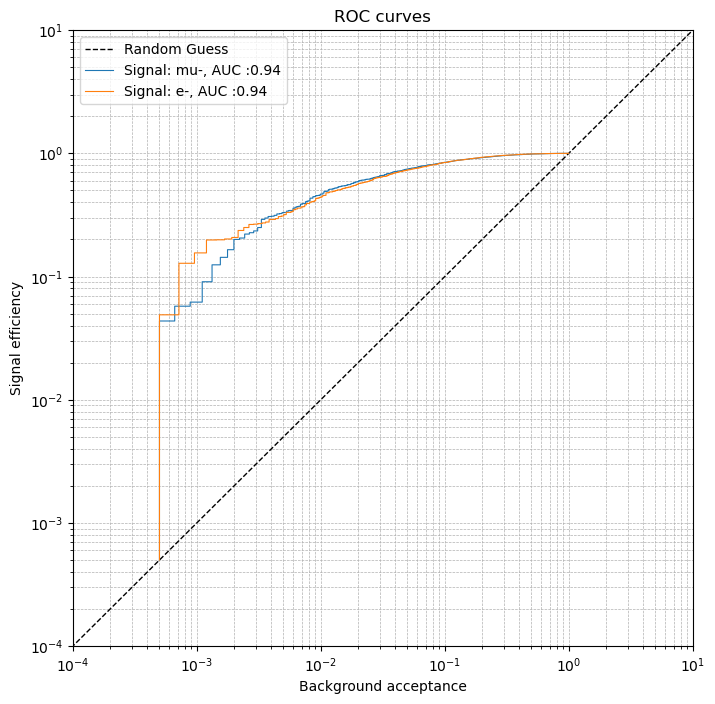

In [37]:
target_names = ['mu-', 'e-'] # order matter

# Global figure parameters
figsize=(8, 8)
log_scale = True

fig, ax = plt.subplots(figsize=figsize)

# Display performances of a random classifier
ax.plot([1e-6, 10], [1e-6, 10], 'k--', label='Random Guess', lw=1)


# --- Computing the ROC curves --- #
for i, target_name in enumerate(target_names):
    signal_index = i # Should be 0 for muon, 1 for electron

    softmax_preds = sp.softmax(preds, axis=1)
    signal_class_preds = softmax_preds[:, signal_index]

    # Compute fpr, tpr and corresponding auc
    fpr, tpr, _ = sk.metrics.roc_curve(targets == signal_index, signal_class_preds)
    roc_auc = sk.metrics.auc(fpr, tpr)

    # Plots
    if log_scale:
        # Handling of 0 values if any
        fpr = np.where(fpr <= 5e-4, 5e-4, fpr)
        tpr = np.where(tpr <= 5e-4, 5e-4, tpr)

    ax.plot(fpr, tpr, label=f"Signal: {target_name}, AUC :{roc_auc:.2f}", lw=0.8)
    ax.legend()



# Increase appearence 
plt.title(f"ROC curves")
ax.set_xlim([1e-4, 10]) 
ax.set_ylim([1e-4, 10])

if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')

plt.grid(True, which='both',  ls='--', lw=0.5)

plt.xlabel('Background acceptance')
plt.ylabel('Signal efficiency')

plt.legend()
plt.show()

In [39]:
save_fig = True
suffix="_test"
if save_fig:
    fig.savefig(viz_folder_path + "roc_curve" + suffix + ".png", dpi=300)

### Performances / energy

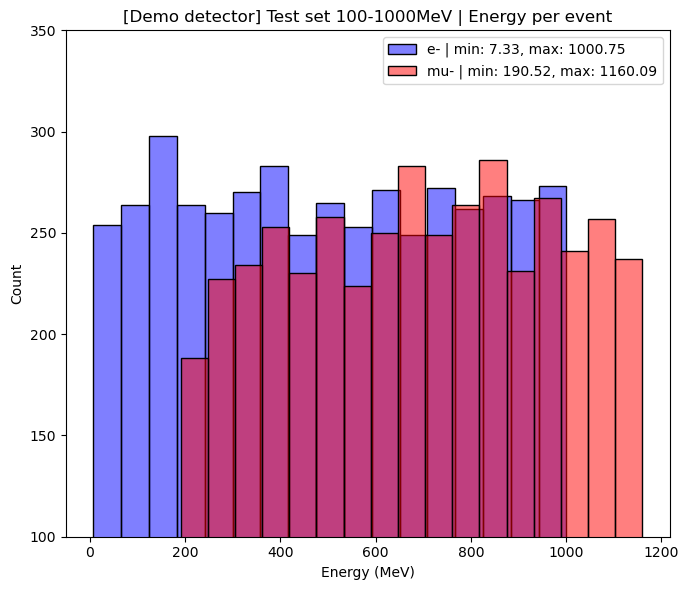

In [62]:
energy = tree['energy'].array()[indices]
electron_e = energy[tree['eventType'].array()[indices] == 11]
muon_e = energy[tree['eventType'].array()[indices] == 13]


fig_title = '[Demo detector] Test set 100-1000MeV | Energy per event'
log_scale=False
alpha=0.5

# Plots nb_hits histograms
plt.figure(figsize=(7, 6))

sns.histplot(electron_e, 
             alpha=alpha,
             log_scale=log_scale,
             label=f'e- | min: {np.min(electron_e):.2f}, max: {np.max(electron_e):.2f}',
             color='blue',
)
sns.histplot(muon_e,
             alpha=alpha,
             log_scale=log_scale,
             label=f"mu- | min: {np.min(muon_e):.2f}, max: {np.max(muon_e):.2f}",
             color='red'
)

plt.ylim([100, 350])
plt.title(fig_title)
plt.xlabel("Energy (MeV)")
plt.legend()

plt.tight_layout()
plt.show()

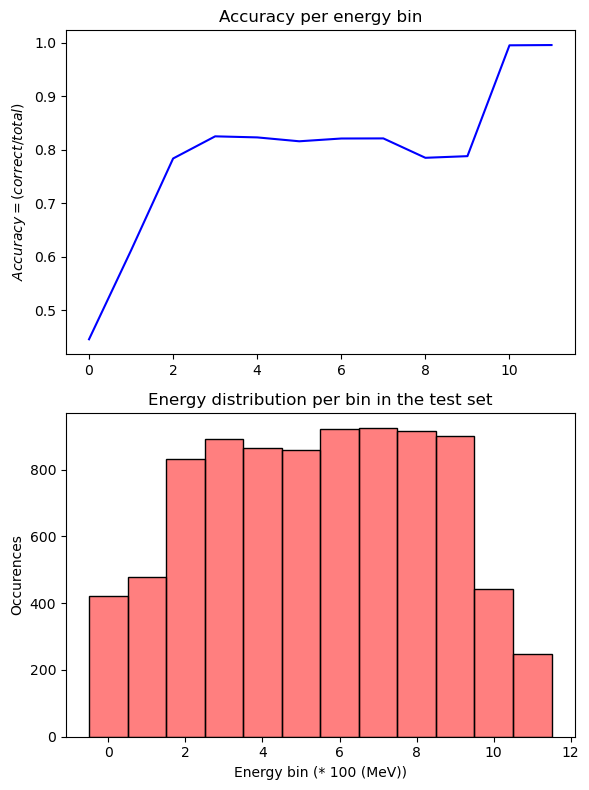

In [66]:

low_e, high_e = 0, 1200
nb_bins = 12
bins = np.linspace(low_e, high_e, nb_bins)


bin_acc = []
bin_indices = np.int32(energy / 100)

for i in range(int(high_e / 100)):
    e_bin_index = np.where(bin_indices == i)
    preds_bin_e = np.argmax(softmax_preds, axis=1)[e_bin_index]
    targets_bin_e = targets[e_bin_index]

    bin_acc.append( np.sum(preds_bin_e == targets_bin_e) / len(e_bin_index[0]))    

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
sns.lineplot(bin_acc, color='blue')
plt.title('Accuracy per energy bin')
plt.ylabel(r'$Accuracy = (correct / total)$')

plt.subplot(2, 1, 2)
sns.histplot(bin_indices, alpha=0.5, color='red', discrete=True)
plt.title('Energy distribution per bin in the test set')
plt.ylabel('Occurences')
plt.xlabel('Energy bin (* 100 (MeV))')

plt.tight_layout()
plt.show()

In [51]:
len(bin_acc), np.unique(bin_indices), len(np.unique(bin_indices))

(12, array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), 12)

In [52]:
bin_acc

[np.float64(0.4452380952380952),
 np.float64(0.6116910229645094),
 np.float64(0.7836538461538461),
 np.float64(0.8251121076233184),
 np.float64(0.823121387283237),
 np.float64(0.8158508158508159),
 np.float64(0.8210412147505423),
 np.float64(0.8212351029252438),
 np.float64(0.7849344978165939),
 np.float64(0.7880133185349611),
 np.float64(0.9954853273137697),
 np.float64(0.9959839357429718)]